working on 19 cases
working on 19791120
getting pressure-level data
getting single-level data
done with downloads, moving on
working on 0000 UTC 16 Nov 1979
plotting 500 vorticity
plotting 850 temperature
plotting 700 q-vectors
plotting 700 wind speed
plotting 250 wind speed
working on 1200 UTC 16 Nov 1979
plotting 500 vorticity
plotting 850 temperature
plotting 700 q-vectors
plotting 700 wind speed
plotting 250 wind speed
getting pressure-level data
getting single-level data
done with downloads, moving on
working on 0000 UTC 17 Nov 1979
plotting 500 vorticity
plotting 850 temperature
plotting 700 q-vectors
plotting 700 wind speed
plotting 250 wind speed
working on 1200 UTC 17 Nov 1979
plotting 500 vorticity
plotting 850 temperature
plotting 700 q-vectors


KeyboardInterrupt: 

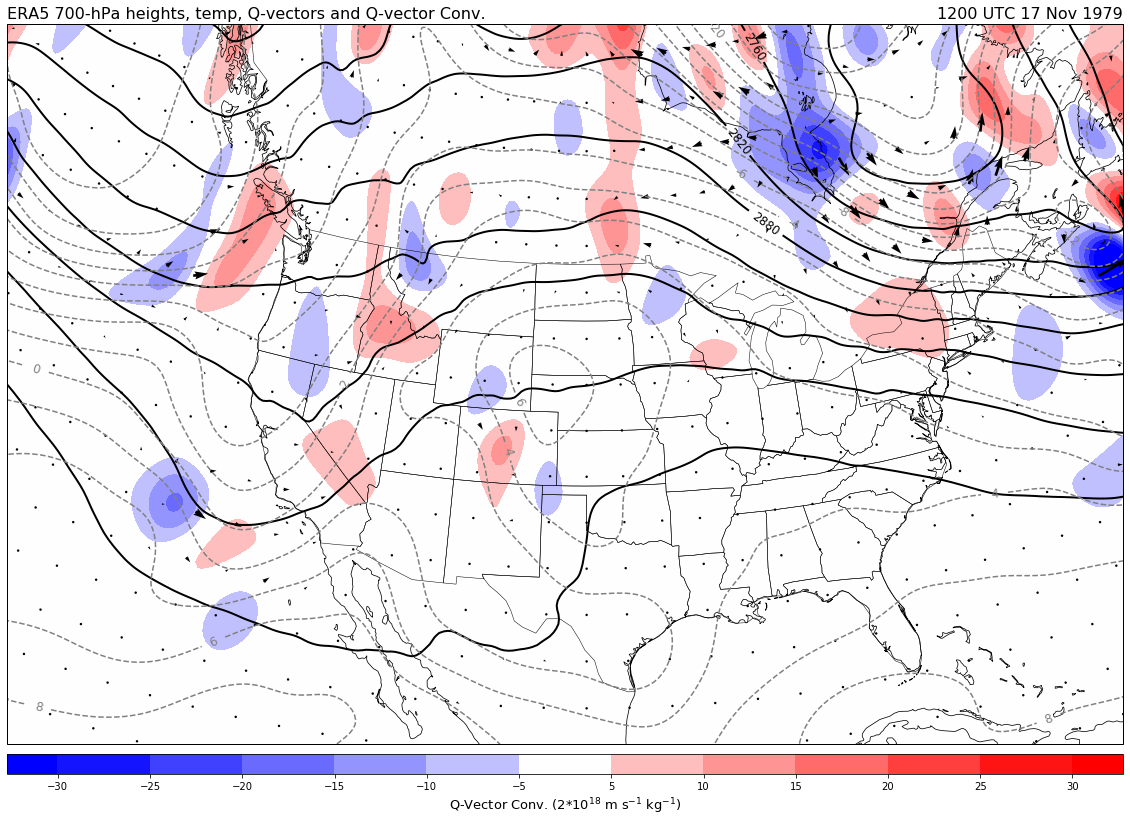

In [24]:
## script to make a series of plots for Fort Collins snowstorms.

## reads in a text file with a list of storms, then goes on to remotely access then plot various fields

#Imports

from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import ctables
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.ncss import NCSS
import cdsapi
import fsspec
import xarray as xr
import matplotlib.colors as mcolors
import os
import pandas as pd
from datetime import datetime,timedelta
from dateutil import rrule

## get our list of cases to work from
#case_date = '20191125'
case_data_all = pd.read_csv('snowstorms_12inch_fortcollins_post1979.csv')

num_cases = case_data_all['start_date'].shape[0]
print('working on '+str(num_cases)+' cases')

## which fields to plot?
plot_250wsp = True
plot_500vort = True
plot_700wsp = True
plot_850temp = True
plot_mslp_thk = False
plot_mslp_precip = False
plot_700qvect = True
plot_dt_theta = False
plot_pwat = False

## loop over cases
for cc in range(0,num_cases):
#for cc in range(16,num_cases):
    
    case_date = case_data_all['start_date'][cc]
    case_date = str(case_date)
    os.system('mkdir -p '+case_date)

    print('working on '+case_date)

    year = case_date[0:4]
    month = case_date[4:6]
    storm_start_day = case_date[6:8]

    plots_start_day = datetime(int(year),int(month),int(storm_start_day),0) - timedelta(days=4)
    plots_end_day = datetime(int(year),int(month),int(storm_start_day),0) + timedelta(days=4)
   
    #Data Acquisition

    year = case_date[0:4]
    month = case_date[4:6]
    storm_start_day = case_date[6:8]

    plots_start_day = datetime(int(year),int(month),int(storm_start_day),0) - timedelta(days=4)
    plots_end_day = datetime(int(year),int(month),int(storm_start_day),0) + timedelta(days=4)

    for date in rrule.rrule(rrule.DAILY,dtstart=plots_start_day,until=plots_end_day):

        
        print('getting pressure-level data')
        
        ## get the data from ECMWF API
        ## instead of downloading it, read it directly
        ## based on: https://nbviewer.jupyter.org/github/pangeo-data/pangeo-era5/blob/master/lazy_loading_expts.ipynb
        c1 = cdsapi.Client()
        name = 'reanalysis-era5-pressure-levels'
        request = {
                'product_type': 'reanalysis',
                'format': 'netcdf',
                'variable': [
                    'geopotential', 'relative_humidity', 'temperature',
                    'u_component_of_wind', 'v_component_of_wind',
                ],
                'pressure_level': [
                    '250', '500', '700',
                    '850', '925', '1000',
                ],
                'year': date.year,
                'month': date.month,
                'day': date.day,
                'time': [
                    '00:00', '12:00',
                ],
                'area'          : [75.,185, 15., 320.] #N,W,S,E
        }
        r1 = c1.retrieve(name, request, None)

        with fsspec.open(r1.location) as f1:
            iso_vars = xr.open_dataset(f1, engine='scipy')
        #    print(iso_vars)

        print('getting single-level data')
        
        ## also need MSLP & PW
        ## get the data from ECMWF API
        c2 = cdsapi.Client()
        name = 'reanalysis-era5-single-levels'
        request = {
                'product_type': 'reanalysis',
                'format': 'netcdf',
                'variable': ['mean_sea_level_pressure','total_column_water_vapour'],
                'year': date.year,
                'month': date.month,
                'day': date.day,
                'time': [
                    '00:00', '12:00',
                ],
                'area'          : [75.,185, 15., 320.] #N,W,S,E
        }
        r2 = c2.retrieve(name, request, None)

        with fsspec.open(r2.location) as f2:
            sl_vars = xr.open_dataset(f2, engine='scipy')
            #print(sl_vars)

        ## get DT theta - but for this we need to go to the ECMWF queue which may take a while...

        if plot_dt_theta:
            
            print('getting DT data from archive')

            c3 = cdsapi.Client()
            name = 'reanalysis-era5-complete'
            request = {
                'class': 'ea',
                'date': date.strftime("%Y")+"-"+date.strftime("%m")+"-"+date.strftime("%d"),
                'expver': '1',
                'levelist': '2000',
                'levtype': 'pv',
                'param': '3.128/54.128/131.128/132.128',
                'stream': 'oper',
                'grid'  : [0.25, 0.25],
                'area'          : [75.,185, 15., 320.], #N,W,S,E
                'time': [
                        '00:00', '12:00',
                    ],
                'type': 'an',
                'format'        : 'netcdf'
                }
            r3 = c3.retrieve(name, request, None)

            with fsspec.open(r3.location) as f3:
                dt_vars = xr.open_dataset(f3, engine='scipy')
            #    print(dt_vars)

        ## now get precip accumulation from EC

        ## what's one day earlier because we need to download that too?
        if plot_mslp_precip:
        
            date_m1 = date - timedelta(days=1)

            print('getting precip data')

            c4 = cdsapi.Client()
            name = 'reanalysis-era5-single-levels'
            request = {
                    'year'          : [date.year,date_m1.year],
                    'month'         : [date.month,date_m1.month],
                    'day': [
                        date.day,date_m1.day,
                    ],
                    'variable'      : 'total_precipitation',
                    'product_type': 'reanalysis',
                    'format'        : 'netcdf',
                    'area'          : [75.,185, 15., 320.], #N,W,S,E
                    'time': [
                        '00:00', '01:00', '02:00',
                        '03:00', '04:00', '05:00',
                        '06:00', '07:00', '08:00',
                        '09:00', '10:00', '11:00',
                        '12:00', '13:00', '14:00',
                        '15:00', '16:00', '17:00',
                        '18:00', '19:00', '20:00',
                        '21:00', '22:00', '23:00',
                    ],
                }
            r4 = c4.retrieve(name, request, None)

            with fsspec.open(r4.location) as f4:
                apcp_var = xr.open_dataset(f4, engine='scipy')
            #    print(apcp_var)

        print('done with downloads, moving on')
        
        ## loop over times in the data for this date
        for tt in range(0,iso_vars.time.shape[0]):
            this_time = pd.to_datetime(iso_vars.time.values)[tt]

            iso_vars_this = iso_vars.sel(time=this_time)
            sl_vars_this = sl_vars.sel(time=this_time)
            vtime = pd.to_datetime(iso_vars_this.time.values)
            
            print("working on "+vtime.strftime("%H%M UTC %d %b %Y"))

            ## pull out needed variables
            lon = iso_vars_this.longitude.data
            lat = iso_vars_this.latitude.data

            ## get 500-mb data to start
            hght_500 = iso_vars_this.z.sel(level=500)/9.81  ## this was geopotential, convert to geopotential height
            uwnd_500 = iso_vars_this.u.sel(level=500)
            vwnd_500 = iso_vars_this.v.sel(level=500)
            
            # less smooth the height a bit
            hght_500 = ndimage.gaussian_filter(hght_500, sigma=1, order=0) * units('m')

            # Combine 1D latitude and longitudes into a 2D grid of locations
            lon_2d, lat_2d = np.meshgrid(lon, lat)
            # Gridshift for barbs
            lon_2d[lon_2d > 180] = lon_2d[lon_2d > 180] - 360

            if plot_500vort:
            
                #Begin Data Calculations
                dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

                f = mpcalc.coriolis_parameter(np.deg2rad(lat_2d)).to(units('1/sec'))

                ## need to set the lats this way since GFS is 1-d
                #avor = mpcalc.absolute_vorticity(uwnd_500,vwnd_500,dx,dy,lat[None,:,None]*units('degrees'))
                avor = mpcalc.vorticity(uwnd_500,vwnd_500,dx,dy) + f

                #smooth
                avor = ndimage.gaussian_filter(avor, sigma=3, order=0) * units('1/s')
                avor = avor.squeeze()  ## remove first empty dimension

                ## vorticity advection
                #vort_adv = mpcalc.advection(avor, [uwnd_500, vwnd_500], (dx,dy)) * 1e9

                ## give units to winds & smooth slightly
                uwnd_500 = ndimage.gaussian_filter(uwnd_500, sigma=1, order=0) * units('m/s')
                vwnd_500 = ndimage.gaussian_filter(vwnd_500, sigma=1, order=0) * units('m/s')

                ## make height plot for testing
                #Map Creation

                print('plotting 500 vorticity')

                # Set Projection of Data
                datacrs = ccrs.PlateCarree()

                # Set Projection of Plot
                plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

                fig = plt.figure(1, figsize=(20,16))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                                       hspace=0.01, wspace=0.01)
                ax = plt.subplot(gs[0], projection=plotcrs)

                # Plot Titles
                plt.title(r'ERA5 500-hPa heights, absolute vorticity, winds',
                          loc='left', fontsize=16)
                plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

                # Plot Background
                ax.set_extent([217.5, 290., 18., 66.])
                ax.coastlines('50m', edgecolor='black', linewidth=0.75)
                ax.add_feature(cfeature.STATES, linewidth=.5)

                # Plot Height Contours
                clev500 = np.arange(5100, 6061, 60)
                cs = ax.contour(lon, lat, hght_500, clev500, colors='black', linewidths=2,
                                linestyles='solid', transform=ccrs.PlateCarree())
                plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                           rightside_up=True, use_clabeltext=True)

                # Absolute Vorticity colors
                # Use two different colormaps from matplotlib and combine into one color set
                clevs_500_avor = list(range(-8, 1, 1))+list(range(12, 36, 1))
                colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 36))
                colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
                colors = np.vstack((colors2, (1, 1, 1, 1), colors1))

                # Plot absolute vorticity values (multiplying by 10^5 to scale appropriately)
                cf = ax.contourf(lon, lat, avor*1e5, clevs_500_avor, colors=colors, extend='max',
                                 transform=datacrs)
                cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, extendrect=True)
                cb.set_label('absolute vorticity ($*10^5 s^{-1}$)', fontsize=13)

                # Plot Wind Barbs
                # Transform Vectors and plot wind barbs.
                wind_slice = slice(None, None, 14)
                ax.barbs(lon[wind_slice], lat[wind_slice], uwnd_500.to(units('kt'))[wind_slice,wind_slice].m, vwnd_500.to(units('kt'))[wind_slice,wind_slice].m, 
                         length=7, linewidth=0.5,pivot='middle', transform=ccrs.PlateCarree())

                outfile="500vort_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".png"
                fig.savefig(outfile)
                plt.close(fig)
                os.system("convert -trim "+outfile+" "+outfile)
                os.system("mv "+outfile+" "+case_date+"/.")

            ## now go on to 850-hPa temperature
            ## with some guidance from here: https://unidata.github.io/python-training/gallery/850hpa_temperature_advection/

            hght_850 = iso_vars_this.z.sel(level=850)/9.81  ## this was geopotential, convert to geopotential height
            uwnd_850 = iso_vars_this.u.sel(level=850)
            vwnd_850 = iso_vars_this.v.sel(level=850)
            tmpk_850 = iso_vars_this.t.sel(level=850)
    
            ## smooth the temperature 
            tmpk_850 = ndimage.gaussian_filter(tmpk_850, sigma=1, order=0) * units('kelvin')
            tmpc_850 = tmpk_850.to(units('degC'))
            hght_850 = ndimage.gaussian_filter(hght_850, sigma=1, order=0) * units('m')

            ## give units to winds & smooth slightly
            uwnd_850 = ndimage.gaussian_filter(uwnd_850, sigma=1, order=0) * units('m/s')
            vwnd_850 = ndimage.gaussian_filter(vwnd_850, sigma=1, order=0) * units('m/s')

            #Map Creation

            if plot_850temp:
            
                print('plotting 850 temperature')
            
                # Set Projection of Data
                datacrs = ccrs.PlateCarree()

                # Set Projection of Plot
                plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

                fig = plt.figure(1, figsize=(20,16))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                                       hspace=0.01, wspace=0.01)
                ax = plt.subplot(gs[0], projection=plotcrs)

                # Plot Titles
                plt.title(r'ERA5 850-hPa heights, temperature, winds',
                          loc='left', fontsize=16)
                plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

                # Plot Background
                ax.set_extent([227.5, 290., 20., 58.])
                ax.coastlines('50m', edgecolor='black', linewidth=0.75)
                ax.add_feature(cfeature.STATES, linewidth=.5)

                # Plot Height Contours
                clev850 = np.arange(0, 3001, 30)
                cs = ax.contour(lon, lat, hght_850, clev850, colors='black', linewidths=2,
                                linestyles='solid', transform=ccrs.PlateCarree())
                plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                           rightside_up=True, use_clabeltext=True)

                # Plot colorfill and dashed contours of 850-hPa temperatures in Celsius
                clevs_850_tmpc = np.arange(-36, 38, 2)
                cf = ax.contourf(lon, lat, tmpc_850, clevs_850_tmpc, cmap=plt.cm.seismic, transform=datacrs)
                cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50)
                cb.set_label('Temperature (C)', fontsize=13)

                ## plot the 0C line
                clev_thk = [0]
                cs4 = ax.contour(lon, lat, tmpc_850, clev_thk, colors='blue',
                                 linewidths=2, transform=ccrs.PlateCarree())
                plt.clabel(cs4, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                                 rightside_up=True, use_clabeltext=True)

                # Plot Wind Barbs
                # Transform Vectors and plot wind barbs.
                wind_slice = slice(None, None, 10)
                ax.barbs(lon[wind_slice], lat[wind_slice], uwnd_850.to(units('kt'))[wind_slice,wind_slice].m, vwnd_850.to(units('kt'))[wind_slice,wind_slice].m, 
                         length=7, linewidth=0.5,pivot='middle', transform=ccrs.PlateCarree())

                outfile="850temp_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".png"
                fig.savefig(outfile)
                plt.close(fig)
                os.system("convert -trim "+outfile+" "+outfile)
                os.system("mv "+outfile+" "+case_date+"/.")

            ## and now q-vectors

            hght_700 = iso_vars_this.z.sel(level=700)/9.81  ## this was geopotential, convert to geopotential height
            uwnd_700 = iso_vars_this.u.sel(level=700)
            vwnd_700 = iso_vars_this.v.sel(level=700)
            tmpk_700 = iso_vars_this.t.sel(level=700)

            ## first, smooth everything pretty heavily:
            tmpk_700 = ndimage.gaussian_filter(tmpk_700, sigma=6, order=0) * units('kelvin')
            uwnd_700 = ndimage.gaussian_filter(uwnd_700, sigma=6, order=0) * units('m/s')
            vwnd_700 = ndimage.gaussian_filter(vwnd_700, sigma=6, order=0) * units('m/s')       
            
            # less smoothing for the height
            hght_700 = ndimage.gaussian_filter(hght_700, sigma=1, order=0) * units('m')
            
            if plot_700qvect:
            
                # Compute the Q-vector components
                uqvect, vqvect = mpcalc.q_vector(uwnd_700, vwnd_700, tmpk_700, 700*units.hPa, dx, dy)

                # Compute the divergence of the Q-vectors calculated above
                q_div = -2*mpcalc.divergence(uqvect, vqvect, dx, dy, dim_order='yx')

                ## smooth it too
                q_div = ndimage.gaussian_filter(q_div, sigma=4, order=0) * units('meter/(kilogram second)')

                #Map Creation

                print('plotting 700 q-vectors')

                # Set Projection of Data
                datacrs = ccrs.PlateCarree()

                # Set Projection of Plot
                plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

                fig = plt.figure(1, figsize=(20,16))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                                       hspace=0.01, wspace=0.01)
                ax = plt.subplot(gs[0], projection=plotcrs)

                # Plot Titles
                plt.title(r'ERA5 700-hPa heights, temp, Q-vectors and Q-vector Conv.',
                          loc='left', fontsize=16)
                plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

                # Plot Background
                ax.set_extent([227.5, 290., 20., 58.])
                ax.coastlines('50m', edgecolor='black', linewidth=0.75)
                ax.add_feature(cfeature.STATES, linewidth=.5)

                # Plot Height Contours
                clev700 = np.arange(0, 5001, 60)
                cs = ax.contour(lon, lat, hght_700, clev700, colors='black', linewidths=2,
                                linestyles='solid', transform=ccrs.PlateCarree())
                plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i', 
                                rightside_up=True, use_clabeltext=True)

                # Plot temperature Contours
                clevtemp700 = np.arange(-30, 20, 2)
                cs2 = ax.contour(lon, lat, tmpk_700.to(units('degC')), clevtemp700, colors='grey',
                                 linewidths=1.5, linestyles='dashed', transform=ccrs.PlateCarree())
                plt.clabel(cs2, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                                 rightside_up=True, use_clabeltext=True)

                # Plot 700-hPa Q-Vector Divergence and scale
                clevs_qdiv = list(range(-30, -4, 5))+list(range(5, 31, 5))
                cf = ax.contourf(lon, lat, q_div*1e18, clevs_qdiv, extend='both',
                                 cmap='bwr', transform=ccrs.PlateCarree())
                cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, extendrect=True,
                                  ticks=clevs_qdiv)
                cb.set_label('Q-Vector Conv. (2*10$^{18}$ m s$^{-1}$ kg$^{-1}$)', fontsize=13)

                # Plot 700-hPa Q-vectors, scale to get nice sized arrows
                wind_slice = slice(None, None, 10)
                ax.quiver(lon[wind_slice],lat[wind_slice],uqvect[wind_slice,wind_slice].m,vqvect[wind_slice,wind_slice].m,
                          pivot='mid', color='black',
                          scale=1e-11, scale_units='inches',
                          transform=ccrs.PlateCarree())


                outfile="700qvect_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".png"
                fig.savefig(outfile)
                plt.close(fig)
                os.system("convert -trim "+outfile+" "+outfile)
                os.system("mv "+outfile+" "+case_date+"/.")
            
            ## do 700-mb wind speed also

            if plot_700wsp:
            
                # Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
                sped_700 = mpcalc.wind_speed(uwnd_700, vwnd_700).to('kt')

                #Map Creation

                print('plotting 700 wind speed')

                # Set Projection of Data
                datacrs = ccrs.PlateCarree()

                # Set Projection of Plot
                plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

                fig = plt.figure(1, figsize=(20., 16))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                                       hspace=0.01, wspace=0.01)
                ax = plt.subplot(gs[0], projection=plotcrs)

                # Plot Titles
                plt.title(r'ERA5 700-hPa heights, winds, and isotachs',
                          loc='left', fontsize=16)
                plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

                # Plot Background
                ax.set_extent([227.5, 290., 20., 58.])
                ax.coastlines('50m', edgecolor='black', linewidth=0.75)
                ax.add_feature(cfeature.STATES, linewidth=.5)

                # Plot Height Contours
                clev700 = np.arange(2400, 18001, 60)
                cs = ax.contour(lon, lat, hght_700, clev700, colors='black', linewidths=2,
                                linestyles='solid', transform=ccrs.PlateCarree())
                plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i', 
                                rightside_up=True, use_clabeltext=True)

                # Plot Colorfill Wind Speeds in knots
                clevs_700_sped = np.arange(30, 100, 10)
                cf = ax.contourf(lon, lat, sped_700, clevs_700_sped, cmap=plt.cm.YlOrRd,
                                 transform=datacrs)
                cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50)
                cb.set_label('wind speed (kt)', fontsize=13)

                # Plot Wind Barbs
                # Transform Vectors and plot wind barbs.
                wind_slice = slice(None, None, 10)
                ax.barbs(lon[wind_slice], lat[wind_slice], uwnd_700.to(units('kt'))[wind_slice,wind_slice].m, vwnd_700.to(units('kt'))[wind_slice,wind_slice].m, 
                         length=7, linewidth=0.5,pivot='middle', transform=ccrs.PlateCarree())

                outfile="700wsp_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".png"
                fig.savefig(outfile)
                plt.close(fig)
                os.system("convert -trim "+outfile+" "+outfile)
                os.system("mv "+outfile+" "+case_date+"/.")

            
            ## now go on to 250-hPa isotachs

            hght_250 = iso_vars_this.z.sel(level=250)/9.81  ## this was geopotential, convert to geopotential height
            uwnd_250 = iso_vars_this.u.sel(level=250)
            vwnd_250 = iso_vars_this.v.sel(level=250)
            tmpk_250 = iso_vars_this.t.sel(level=250)

            uwnd_250 = ndimage.gaussian_filter(uwnd_250, sigma=1, order=0) * units('m/s')
            vwnd_250 = ndimage.gaussian_filter(vwnd_250, sigma=1, order=0) * units('m/s')

            if plot_250wsp:
            
                # Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
                sped_250 = mpcalc.wind_speed(uwnd_250, vwnd_250).to('kt')

                #Map Creation

                print('plotting 250 wind speed')

                # Set Projection of Data
                datacrs = ccrs.PlateCarree()

                # Set Projection of Plot
                plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

                fig = plt.figure(1, figsize=(20,16))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                                       hspace=0.01, wspace=0.01)
                ax = plt.subplot(gs[0], projection=plotcrs)

                # Plot Titles
                plt.title(r'ERA5 250-hPa heights, winds, and isotachs',
                          loc='left', fontsize=16)
                plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

                # Plot Background
                ax.set_extent([217.5, 290., 18., 66.])
                ax.coastlines('50m', edgecolor='black', linewidth=0.75)
                ax.add_feature(cfeature.STATES, linewidth=.5)

                # Plot Height Contours
                clev250 = np.arange(6000, 18001, 60)
                cs = ax.contour(lon, lat, hght_250, clev250, colors='black', linewidths=2,
                                linestyles='solid', transform=ccrs.PlateCarree())
                plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i', 
                                rightside_up=True, use_clabeltext=True)

                # Plot Colorfill Wind Speeds in knots
                clevs_250_sped = np.arange(70, 210, 20)
                cf = ax.contourf(lon, lat, sped_250, clevs_250_sped, cmap=plt.cm.YlOrRd,
                                 transform=datacrs)
                cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50)
                cb.set_label('wind speed (kt)', fontsize=13)

                # Plot Wind Barbs
                # Transform Vectors and plot wind barbs.
                wind_slice = slice(None, None, 14)
                ax.barbs(lon[wind_slice], lat[wind_slice], uwnd_250.to(units('kt'))[wind_slice,wind_slice].m, vwnd_250.to(units('kt'))[wind_slice,wind_slice].m, 
                         length=7, linewidth=0.5,pivot='middle', transform=ccrs.PlateCarree())

                outfile="250wsp_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".png"
                fig.savefig(outfile)
                plt.close(fig)
                os.system("convert -trim "+outfile+" "+outfile)
                os.system("mv "+outfile+" "+case_date+"/.")

            ## Now MSLP and 700-mb RH
            rh_700 = iso_vars_this.r.sel(level=700)

            hght_1000 = iso_vars_this.z.sel(level=1000)/9.81
            hght_1000 = ndimage.gaussian_filter(hght_1000, sigma=1, order=0) * units('m')

            thk_1000_500 = hght_500 - hght_1000

            mslp = ndimage.gaussian_filter(sl_vars_this.msl.data, sigma=2, order=0) * units('Pa')
            thk_1000_500 = ndimage.gaussian_filter(thk_1000_500, sigma=1, order=0) * units('m')
            
            #Map Creation

            if plot_mslp_thk:
            
                print('plotting MSLP/RH')

                # Set Projection of Data
                datacrs = ccrs.PlateCarree()

                # Set Projection of Plot
                plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

                fig = plt.figure(1, figsize=(20,16))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                                       hspace=0.01, wspace=0.01)
                ax = plt.subplot(gs[0], projection=plotcrs)

                # Plot Titles
                plt.title(r'ERA5 MSLP, 1000--500-hPa thickness, and 700-hPa RH',
                          loc='left', fontsize=16)
                plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

                # Plot Background
                ax.set_extent([227.5, 290., 20., 58.])
                ax.coastlines('50m', edgecolor='black', linewidth=0.75)
                ax.add_feature(cfeature.STATES, linewidth=.5)

                # Plot MSLP Contours
                clev_mslp = np.arange(940,1060,4)
                cs = ax.contour(lon, lat, mslp.to(units('hPa')), clev_mslp, colors='black', linewidths=2,
                                linestyles='solid', transform=ccrs.PlateCarree())
                plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i', 
                                rightside_up=True, use_clabeltext=True)

                # Plot thickness Contours
                clev_thk = np.arange(5100,5400,60)
                cs2 = ax.contour(lon, lat, thk_1000_500, clev_thk, colors='blue',
                                 linewidths=1.5, linestyles='dashed', transform=ccrs.PlateCarree())
                plt.clabel(cs2, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                                 rightside_up=True, use_clabeltext=True)
                ## above 5400
                clev_thk = np.arange(5460,6000,60)
                cs3 = ax.contour(lon, lat, thk_1000_500, clev_thk, colors='red',
                                 linewidths=1.5, linestyles='dashed', transform=ccrs.PlateCarree())
                plt.clabel(cs3, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                                 rightside_up=True, use_clabeltext=True)
                ## and the 5400 line
                clev_thk = [5400]
                cs4 = ax.contour(lon, lat, thk_1000_500, clev_thk, colors='red',
                                 linewidths=2, transform=ccrs.PlateCarree())
                plt.clabel(cs4, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                                 rightside_up=True, use_clabeltext=True)

                # Plot Colorfill RH
                clevs_700_rh = np.arange(70,110,5)
                cf = ax.contourf(lon, lat, rh_700, clevs_700_rh, cmap=plt.cm.Greens,
                                 transform=datacrs)
                cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50)
                cb.set_label('RH (%)', fontsize=13)

                outfile="mslp_thk_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".png"
                fig.savefig(outfile)
                plt.close(fig)
                os.system("convert -trim "+outfile+" "+outfile)
                os.system("mv "+outfile+" "+case_date+"/.")
            
            #Map Creation

            if plot_pwat:
            
                print('plotting PW')

                # Set Projection of Data
                datacrs = ccrs.PlateCarree()

                # Set Projection of Plot
                plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

                fig = plt.figure(1, figsize=(20,16))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                                       hspace=0.01, wspace=0.01)
                ax = plt.subplot(gs[0], projection=plotcrs)

                # Plot Titles
                plt.title(r'ERA5 precipitable water and 700-mb winds',
                          loc='left', fontsize=16)
                plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

                # Plot Background
                ax.set_extent([227.5, 290., 20., 58.])
                ax.coastlines('50m', edgecolor='black', linewidth=0.75)
                ax.add_feature(cfeature.STATES, linewidth=.5)

                # Plot Colorfill PW
                clevs_pwat = np.arange(5,70,5)
                cf = ax.contourf(lon,lat, sl_vars_this.tcwv.data, clevs_pwat, cmap=plt.cm.Greens,
                                 transform=datacrs)
                cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50)
                cb.set_label('precipitable water (mm)', fontsize=13)

                # Plot Wind Barbs
                # Transform Vectors and plot wind barbs.
                wind_slice = slice(None, None, 12)
                ax.barbs(lon[wind_slice], lat[wind_slice], uwnd_700.to(units('kt'))[wind_slice,wind_slice].m, vwnd_700.to(units('kt'))[wind_slice,wind_slice].m, 
                         length=7, linewidth=0.5,pivot='middle', transform=ccrs.PlateCarree())

                outfile="pwat_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".png"
                fig.savefig(outfile)
                plt.close(fig)
                os.system("convert -trim "+outfile+" "+outfile)
                os.system("mv "+outfile+" "+case_date+"/.")

            # Now DT theta and winds

            if plot_dt_theta:
            
                dt_vars_this = dt_vars.sel(time=this_time)
            
                ## smooth the theta and winds
                dt_theta = ndimage.gaussian_filter(dt_vars_this.pt.data, sigma=3, order=0) * units('kelvin')
                dt_uwnd = ndimage.gaussian_filter(dt_vars_this.u.data, sigma=2, order=0) * units('kt')
                dt_vwnd = ndimage.gaussian_filter(dt_vars_this.v.data, sigma=2, order=0) * units('kt')

                dt_lon = dt_vars_this.longitude.data
                dt_lat = dt_vars_this.latitude.data

                ## also calculate the low-level relative vort:
                relvor_850 = mpcalc.vorticity(uwnd_850,vwnd_850,dx,dy) 

                #smooth
                relvor_850 = ndimage.gaussian_filter(relvor_850, sigma=1, order=0) * units('1/s')
                relvor_850 = relvor_850.squeeze() ## remove first empty dimension

                #Map Creation

                print('plotting DT theta')

                # Set Projection of Data
                datacrs = ccrs.PlateCarree()

                # Set Projection of Plot
                plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

                fig = plt.figure(1, figsize=(20,16))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                                       hspace=0.01, wspace=0.01)
                ax = plt.subplot(gs[0], projection=plotcrs)

                # Plot Titles
                plt.title(r'ERA5 dynamic tropopause potential temperature and winds; 850-hPa relative vorticity',
                          loc='left', fontsize=16)
                plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

                # Plot Background
                ax.set_extent([217.5, 290., 18., 66.])
                ax.coastlines('50m', edgecolor='black', linewidth=0.75)
                ax.add_feature(cfeature.STATES, linewidth=.5)

                # Plot Colorfill DT theta
                clevs_dt = np.arange(260,400,5)
                cf = ax.contourf(dt_lon, dt_lat, dt_theta, clevs_dt, cmap=plt.cm.twilight_shifted,
                                 transform=datacrs)
                cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50)
                cb.set_label('potential temperature (K)', fontsize=13)

                # Plot 850-mb vort contours
                clev_relvor = np.arange(4,40,4)
                cs = ax.contour(lon, lat, relvor_850*1e5, clev_relvor, colors='black', linewidths=2,
                                linestyles='solid', transform=ccrs.PlateCarree())
                plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i', 
                                rightside_up=True, use_clabeltext=True)

                # Plot Wind Barbs
                # Transform Vectors and plot wind barbs.
                wind_slice = slice(None, None, 14)
                ax.barbs(dt_lon[wind_slice], dt_lat[wind_slice], dt_uwnd[wind_slice,wind_slice].m, dt_vwnd[wind_slice,wind_slice].m, 
                         length=7, linewidth=0.5,pivot='middle', transform=ccrs.PlateCarree())

                outfile="dt_theta_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".png"
                fig.savefig(outfile)
                plt.close(fig)
                os.system("convert -trim "+outfile+" "+outfile)
                os.system("mv "+outfile+" "+case_date+"/.")
 
            # now precip/MSLP
    
            if plot_mslp_precip:
    
                # convert from m to mm
                apcp = 1000.*apcp_var.tp

                ## and calculate sum over 12-hour period
                apcp_tot = apcp.rolling(time=12).sum()

                # find this time
                apcp_tot_this = apcp_tot.sel(time=this_time)

                # plot MSLP/thickness/precip
                #Map Creation

                print('plotting MSLP/thickness/precip')

                # Set Projection of Data
                datacrs = ccrs.PlateCarree()

                # Set Projection of Plot
                plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

                fig = plt.figure(1, figsize=(20,16))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                                       hspace=0.01, wspace=0.01)
                ax = plt.subplot(gs[0], projection=plotcrs)

                # Plot Titles
                plt.title(r'ERA5 MSLP, 1000--500-hPa thickness, and precip in previous 12 hours',
                          loc='left', fontsize=16)
                plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

                # Plot Background
                ax.set_extent([227.5, 290., 20., 58.])
                ax.coastlines('50m', edgecolor='black', linewidth=0.75)
                ax.add_feature(cfeature.STATES, linewidth=.5)

                # Plot MSLP Contours
                clev_mslp = np.arange(940,1060,4)
                cs = ax.contour(lon, lat, mslp.to(units('hPa')), clev_mslp, colors='black', linewidths=2,
                                linestyles='solid', transform=ccrs.PlateCarree())
                plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i', 
                                rightside_up=True, use_clabeltext=True)

                # Plot thickness Contours
                clev_thk = np.arange(5100,5400,60)
                cs2 = ax.contour(lon, lat, thk_1000_500, clev_thk, colors='blue',
                                 linewidths=1.5, linestyles='dashed', transform=ccrs.PlateCarree())
                plt.clabel(cs2, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                                 rightside_up=True, use_clabeltext=True)
                ## above 5400
                clev_thk = np.arange(5460,6000,60)
                cs3 = ax.contour(lon, lat, thk_1000_500, clev_thk, colors='red',
                                 linewidths=1.5, linestyles='dashed', transform=ccrs.PlateCarree())
                plt.clabel(cs3, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                                 rightside_up=True, use_clabeltext=True)
                ## and the 5400 line
                clev_thk = [5400]
                cs4 = ax.contour(lon, lat, thk_1000_500, clev_thk, colors='red',
                                 linewidths=2, transform=ccrs.PlateCarree())
                plt.clabel(cs4, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                                 rightside_up=True, use_clabeltext=True)

                # Plot Colorfill precip
                # draw filled contours.
                clevs = [0,1,2.5,5,10,15,20,25,37.5,50,62.5,75,100,112.5,125,150,175,200]
                cmap_data = [(1.000000, 1.000000, 1.000000),
                (0.498039, 1.000000, 0.000000),
                (0.000000, 0.803922, 0.000000),
                (0.000000, 0.545098, 0.000000),
                (0.062745, 0.305882, 0.545098),
                (0.117647, 0.564706, 1.000000),
                (0.000000, 0.698039, 0.933333),
                (0.000000, 0.933333, 0.933333),
                (0.537255, 0.407843, 0.803922),
                (0.568627, 0.172549, 0.933333),
                (0.545098, 0.000000, 0.545098),
                (0.545098, 0.000000, 0.000000),
                (0.803922, 0.000000, 0.000000),
                (0.933333, 0.250980, 0.000000),
                (1.000000, 0.498039, 0.000000),
                (0.803922, 0.521569, 0.000000),
                (1.000000, 0.843137, 0.000000)]
                cmap = mcolors.ListedColormap(cmap_data, 'precip_rss')
                norm = mcolors.BoundaryNorm(clevs, cmap.N)

                # In future MetPy
                #norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)

                cf = ax.contourf(apcp_var.longitude.data, apcp_var.latitude.data, apcp_tot_this, clevs, cmap=cmap, norm=norm,
                                 transform=datacrs)
                cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50)
                cb.set_label('precipitation (mm)', fontsize=13)

                outfile="mslp_prcp_thk_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".png"
                fig.savefig(outfile)
                plt.close(fig)
                os.system("convert -trim "+outfile+" "+outfile)
                os.system("mv "+outfile+" "+case_date+"/.")


In [20]:
pd.to_datetime(iso_vars.time.values)[0].year
#for this_time in iso_vars.time:
#    print(datetime(this_time).year)

for tt in range(0,iso_vars.time.shape[0]):
    this_time = pd.to_datetime(iso_vars.time.values)[tt]
    print(this_time)

#iso_vars.time.shape[0]


1979-11-16 00:00:00
1979-11-16 12:00:00


In [21]:
iso_vars_this = iso_vars.sel(time=this_time)

In [22]:
iso_vars_this

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 6, longitude: 541)
Coordinates:
  * longitude  (longitude) float32 185.0 185.25 185.5 ... 319.5 319.75 320.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 15.5 15.25 15.0
  * level      (level) int32 250 500 700 850 925 1000
    time       datetime64[ns] 1979-11-16T12:00:00
Data variables:
    z          (level, latitude, longitude) float32 ...
    r          (level, latitude, longitude) float32 ...
    t          (level, latitude, longitude) float32 ...
    u          (level, latitude, longitude) float32 ...
    v          (level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-02-28 23:08:52 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...